<a href="https://colab.research.google.com/github/leeyjin1/usb-serial-for-android/blob/master/Copy_of_pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multivariate Time Series Forecasting with LSTMs in Keras
by Jason Brownlee on October 21, 2020 in Deep Learning for Time Series

Neural networks like Long Short-Term Memory (LSTM) recurrent neural networks are able to almost seamlessly model problems with multiple input variables.

This is a great benefit in time series forecasting, where classical linear methods can be difficult to adapt to multivariate or multiple input forecasting problems.

In this tutorial, you will discover how you can develop an LSTM model for multivariate time series forecasting with the Keras deep learning library.

After completing this tutorial, you will know:

How to transform a raw dataset into something we can use for time series forecasting.
How to prepare data and fit an LSTM for a multivariate time series forecasting problem.
How to make a forecast and rescale the result back into the original units.
Kick-start your project with my new book Deep Learning for Time Series Forecasting, including step-by-step tutorials and the Python source code files for all examples.

##Tutorial Overview
This tutorial is divided into 4 parts; they are:

* Air Pollution Forecasting
* Basic Data Preparation
* Multivariate LSTM Forecast Model
 * LSTM Data Preparation
 * Define and Fit Model
 * Evaluate Model
 * Complete Example
* Train On Multiple Lag Timesteps Example
###Python Environment
This tutorial assumes you have a Python SciPy environment installed. I recommend that youuse Python 3 with this tutorial.

You must have Keras (2.0 or higher) installed with either the TensorFlow or Theano backend, Ideally Keras 2.3 and TensorFlow 2.2, or higher.

The tutorial also assumes you have scikit-learn, Pandas, NumPy and Matplotlib installed.

##Air Pollution Forecasting
In this tutorial, we are going to use the Air Quality dataset.

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* pm2.5: PM2.5 concentration
* DEWP: Dew Point
* TEMP: Temperature
* PRES: Pressure
* cbwd: Combined wind direction
* Iws: Cumulated wind speed
* Is: Cumulated hours of snow
* Ir: Cumulated hours of rain
We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

This dataset can be used to frame other forecasting problems.

You can download the dataset from the UCI Machine Learning Repository.

Beijing PM2.5 Data Set

Download the dataset and place it in your current working directory with the filename “raw.csv“.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/WearData/pollution/')

##Basic Data Preparation

The data is not ready to use. We must prepare it first.

The first step is to consolidate the date-time information into a single date-time so that we can use it as an index in Pandas.

A quick check reveals NA values for pm2.5 for the first 24 hours. We will, therefore, need to remove the first row of data. There are also a few scattered “NA” values later in the dataset; we can mark them with 0 values for now.

The script below loads the raw dataset and parses the date-time information as the Pandas DataFrame index. The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.

The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.

In [ ]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
 return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


Now that we have the data in an easy-to-use form, we can create a quick plot of each series and see what we have.

The code below loads the new “pollution.csv” file and plots each series as a separate subplot, except wind speed dir, which is categorical.

Running the example creates a plot with 7 subplots showing the 5 years of data for each variable.

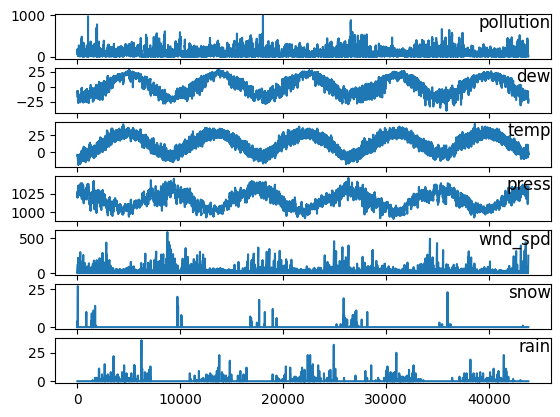

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

# Multivariate LSTM Forecast Model
In this section, we will fit an LSTM to the problem.

##LSTM Data Preparation
The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

This formulation is straightforward and just for this demonstration. Some alternate formulations you could explore include:

Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.
We can transform the dataset using the series_to_supervised() function developed in the blog post:

How to Convert a Time Series to a Supervised Learning Problem in Python
First, the “pollution.csv” dataset is loaded. The wind direction feature is label encoded (integer encoded). This could further be one-hot encoded in the future if you are interested in exploring it.

Next, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.

The complete code listing is provided below.

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())



   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


This data preparation is simple and there is more we could explore. Some ideas you could look at include:

One-hot encoding wind direction.
Making all series stationary with differencing and seasonal adjustment.
Providing more than 1 hour of input time steps.
This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

##Define and Fit Model
In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
Epoch 1/50
122/122 - 5s - loss: 0.0584 - val_loss: 0.0504 - 5s/epoch - 37ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0401 - val_loss: 0.0469 - 2s/epoch - 14ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0230 - val_loss: 0.0392 - 1s/epoch - 12ms/step
Epoch 4/50
122/122 - 3s - loss: 0.0170 - val_loss: 0.0316 - 3s/epoch - 28ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0156 - val_loss: 0.0205 - 2s/epoch - 16ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0150 - val_loss: 0.0174 - 2s/epoch - 15ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0165 - 1s/epoch - 12ms/step
Epoch 8/50
122/122 - 2s - loss: 0.0149 - val_loss: 0.0165 - 2s/epoch - 14ms/step
Epoch 9/50
122/122 - 2s - loss: 0.0149 - val_loss: 0.0160 - 2s/epoch - 14ms/step
Epoch 10/50
122/122 - 2s - loss: 0.0149 - val_loss: 0.0156 - 2s/epoch - 14ms/step
Epoch 11/50
122/122 - 4s - loss: 0.0147 - val_loss: 0.0154 - 4s/epoch - 29ms/step
Epoch 12/50
122/122 - 2s - loss: 0.0147 - val_loss: 0.0151 - 2s

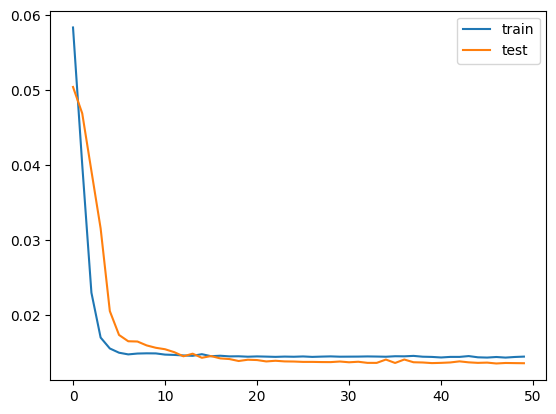

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


#Evaluate Model
After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

1095/1095 [==============================] - 4s 3ms/step
Test RMSE: 26.535


#Train On Multiple Lag Timesteps Example
There have been many requests for advice on how to adapt the above example to train the model on multiple previous time steps.

I had tried this and a myriad of other configurations when writing the original post and decided not to include them because they did not lift model skill.

Nevertheless, I have included this example below as reference template that you could adapt for your own problems.

The changes needed to train the model on multiple previous time steps are quite minimal, as follows:

First, you must frame the problem suitably when calling series_to_supervised(). We will use 3 hours of data as input. Also note, we no longer explictly drop the columns from all of the other fields at ob(t).

Next, we need to be more careful in specifying the column for input and output.

We have 3 * 8 + 8 columns in our framed dataset. We will take 3 * 8 or 24 columns as input for the obs of all features across the previous 3 hours. We will take just the pollution variable as output at the following hour, as follows:

Next, we can reshape our input data correctly to reflect the time steps and features.

Fitting the model is the same.

The only other small change is in how to evaluate the model. Specifically, in how we reconstruct the rows with 8 columns suitable for reversing the scaling operation to get the y and yhat back into the original scale so that we can calculate the RMSE.

The gist of the change is that we concatenate the y or yhat column with the last 7 features of the test dataset in order to inverse the scaling, as follows:



(43797, 32)
(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)
Epoch 1/50
122/122 - 5s - loss: 0.0504 - val_loss: 0.0684 - 5s/epoch - 38ms/step
Epoch 2/50
122/122 - 3s - loss: 0.0268 - val_loss: 0.0492 - 3s/epoch - 28ms/step
Epoch 3/50
122/122 - 2s - loss: 0.0219 - val_loss: 0.0323 - 2s/epoch - 16ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0217 - val_loss: 0.0273 - 2s/epoch - 14ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0205 - val_loss: 0.0252 - 2s/epoch - 14ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0205 - val_loss: 0.0223 - 2s/epoch - 13ms/step
Epoch 7/50
122/122 - 2s - loss: 0.0196 - val_loss: 0.0214 - 2s/epoch - 15ms/step
Epoch 8/50
122/122 - 2s - loss: 0.0197 - val_loss: 0.0203 - 2s/epoch - 13ms/step
Epoch 9/50
122/122 - 3s - loss: 0.0187 - val_loss: 0.0208 - 3s/epoch - 29ms/step
Epoch 10/50
122/122 - 2s - loss: 0.0188 - val_loss: 0.0195 - 2s/epoch - 16ms/step
Epoch 11/50
122/122 - 2s - loss: 0.0180 - val_loss: 0.0195 - 2s/epoch - 13ms/step
Epoch 12/50
122/122 - 2s - 

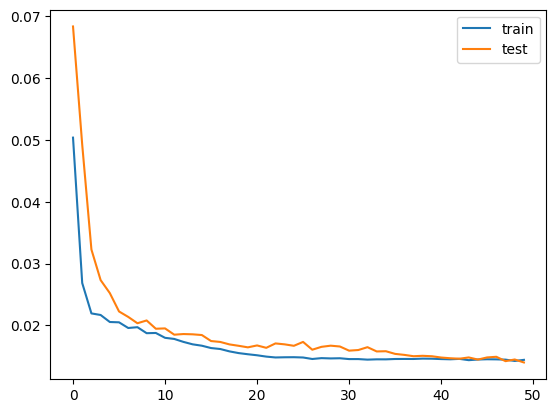

1095/1095 [==============================] - 4s 3ms/step
Test RMSE: 26.563


In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)